# Make figures for DF project

* Number fluctuation at different bacterial concentration
20, 40, 60, 80 and 100 n$_0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata

## Functions
* These functions will be collected in a library later

In [46]:
def readdata(folder):
    dataDirs = dirrec(folder, '*.csv')
    nameList = []
    dirList = []
    for dataDir in dataDirs:
        path, file = os.path.split(dataDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(dataDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList = fileList.sort_values(by=['Name'])
    return fileList

In [4]:
def average_NF(folder, avrange=[250, 500]):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if i.Name < avrange[0] or i.Name > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

In [120]:
def corrlength(corrData, deg, fitting_range=1000):
    xx = np.array(corrData.R)
    yy = np.array(corrData.C)
    x = xx[xx<fitting_range]
    y = yy[xx<fitting_range]
    p = np.polyfit(x, y, deg)
    xsolve = np.linspace(0, x.max(), int(x.max()))
    yfit = np.dot(polyvander(xsolve, deg), np.flip(p).transpose())
    for xm, ym in zip(xsolve, yfit):
        if ym > (1 / np.e):
            continue
        else:
            return xm

In [47]:
def average_cav(folder):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

## Figure implementations

#### Figure 1 - experiment
* Raw image from microscopy
* Spatial intensity variation

#### Figure 2 - GNF
* Deviation from CLT
* Slope vs. concentration

In [7]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

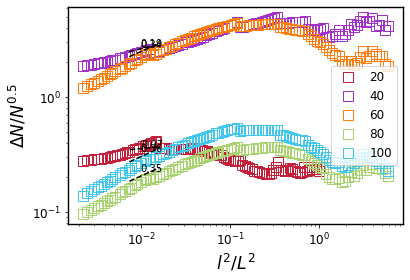

In [10]:
# GNF data
# Normalization of data is needed 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n/420**2
    yy = subdata.d/subdata.n**.5       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

* Generate the data that are used in the plot

Text(0, 0.5, 'slope')

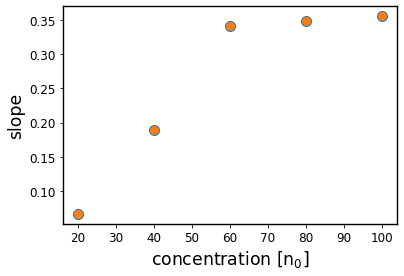

In [62]:
n = [20, 40, 60, 80, 100]
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

#### Figure 3 - intensity spatial correlation
* correlation vs. distance
* correlation length vs. concentration

In [28]:
# Average over 100 frames
folder = r'D:\Wei\Dynamics_raw\cl_result'
n = [20, 40, 60, 80, 100]
data = pd.DataFrame()
for nt in n:    
    subdata = average_NF(os.path.join(folder, str(nt)), avrange=[400, 1000])
    data = data.append(subdata.assign(conc=nt))

Text(0, 0.5, 'Correlation')

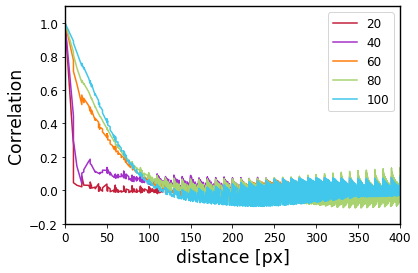

In [34]:
# Plot raw data
count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    plt.plot(subdata.R, subdata.C, color=wowcolor(count), label=str(nt))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

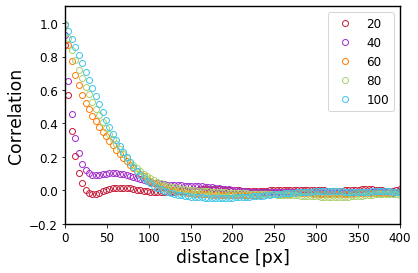

In [48]:
# Polynomial fitting in range
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'correlation')

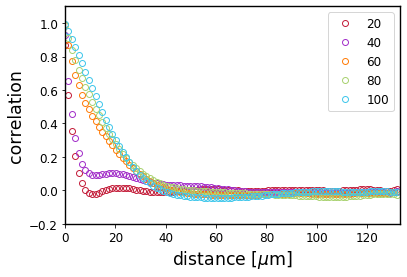

In [67]:
# Convert unit to um
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 133, -0.2, 1.1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('correlation')

Text(0, 0.5, 'correlation length [$\\mu$m]')

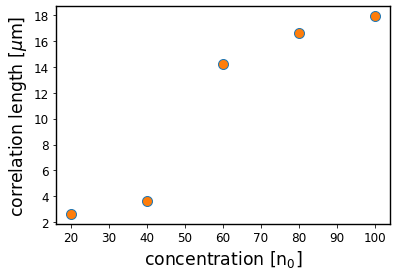

In [68]:
# Extract correlation length - based on polynomial fitting
deg = 8 # degree of polynomial fitting
sparcity = 1 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

n = [20, 40, 60, 80, 100]
cl = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl.append(corrlength(subdata, 10))
plt.plot(n, np.array(cl)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('correlation length [$\mu$m]')

In [39]:
# Save data
# data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv', index=False)

#### Figure 4 - velocity and orientation spatial correlation
* velocity correlation 2D
* velocity correlation length vs. concentration
* orientation correlation 2D
* orientation correlation length vs. concentration

In [2]:
# From PIV to correlation
folder = r'D:\Wei\Dynamics_raw\piv_result\100'
pivData = pd.read_csv(os.path.join(folder, '900-901.csv'))
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))
CA, CV = corrS(X, Y, U, V)

In [102]:
# Large volume data
folder = r'D:\Wei\Dynamics_raw\cav_result\40'
data = average_cav(folder)

In [103]:
# Crop and save data
CA = np.array(data.CA).reshape(80, 80)[0:20, 0:20]
CV = np.array(data.CV).reshape(80, 80)[0:20, 0:20] * 6400
save_folder = r'I:\Google Drive\Research projects\DF\Figures\fig4-VACorr'
# np.savetxt(os.path.join(save_folder, 'CA40.dat'), CA)
# np.savetxt(os.path.join(save_folder, 'CV40.dat'), CV)

<IPython.core.display.Javascript object>


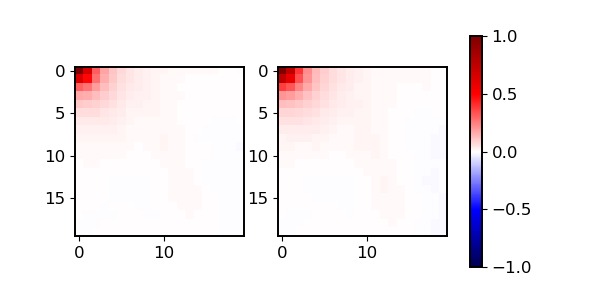

In [104]:
# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
z0 = ax[0].imshow(CA, cmap='seismic', vmin=-1, vmax=1)
z1 = ax[1].imshow(CV, cmap='seismic', vmin=-1, vmax=1)
fig.colorbar(z0, ax=ax)

In [106]:
# scalar distance correlation C(r)
step = 25
x = np.linspace(0, 20, 20) * step
y = np.linspace(0, 20, 20) * step
X, Y = np.meshgrid(x, y)

<IPython.core.display.Javascript object>


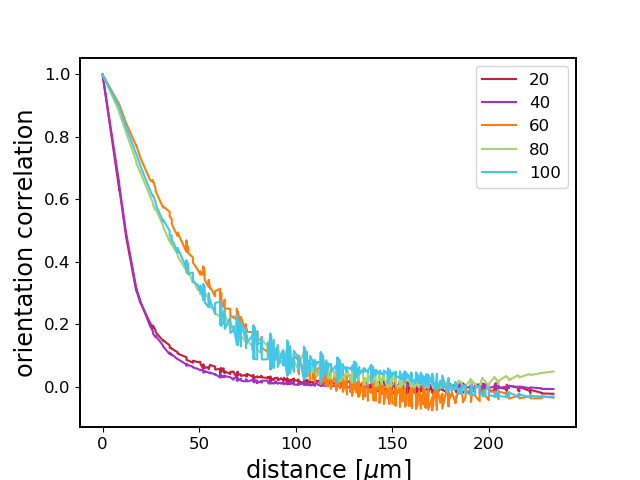

Text(0, 0.5, 'orientation correlation')

In [134]:
mpp = 0.33
folder = r'I:\Google Drive\Research projects\DF\Figures\fig4-VACorr'
l = dirrec(folder, 'CA*')
clA = []
count = 0
for d in l:
    CA = np.loadtxt(d)
    dc = distance_corr(X, Y, CA)
    clA.append(corrlength(dc, 8))
    plt.plot(dc.R*mpp, dc.C, color=wowcolor(count))
    count += 1
plt.legend(['20', '40', '60', '80', '100'])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('orientation correlation')

<IPython.core.display.Javascript object>


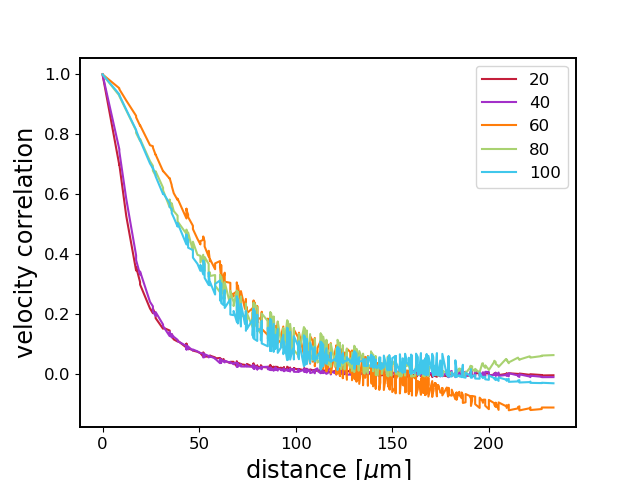

Text(0, 0.5, 'velocity correlation')

In [135]:
mpp = 0.33
folder = r'I:\Google Drive\Research projects\DF\Figures\fig4-VACorr'
l = dirrec(folder, 'CV*')
clV = []
count = 0
for d in l:
    CA = np.loadtxt(d)
    dc = distance_corr(X, Y, CA)
    clV.append(corrlength(dc, 8))
    plt.plot(dc.R*mpp, dc.C, color=wowcolor(count))
    count += 1
plt.legend(['20', '40', '60', '80', '100'])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('velocity correlation')

<IPython.core.display.Javascript object>


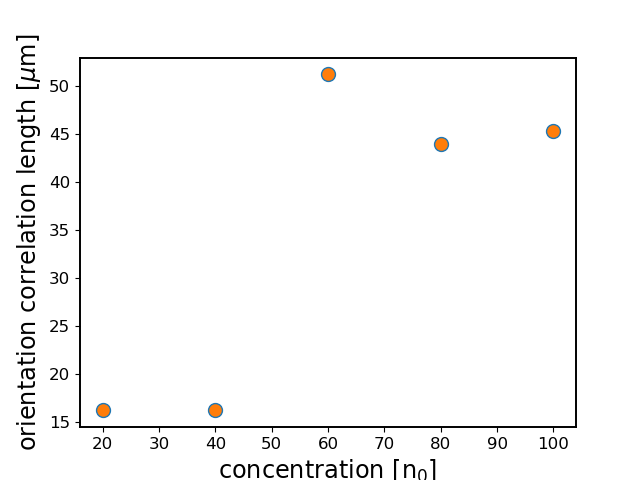

Text(0, 0.5, 'orientation correlation length [$\\mu$m]')

In [132]:
# plot correlation length
n = [20, 40, 60, 80, 100]
plt.plot(n, np.array(clA)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('orientation correlation length [$\mu$m]')

<IPython.core.display.Javascript object>


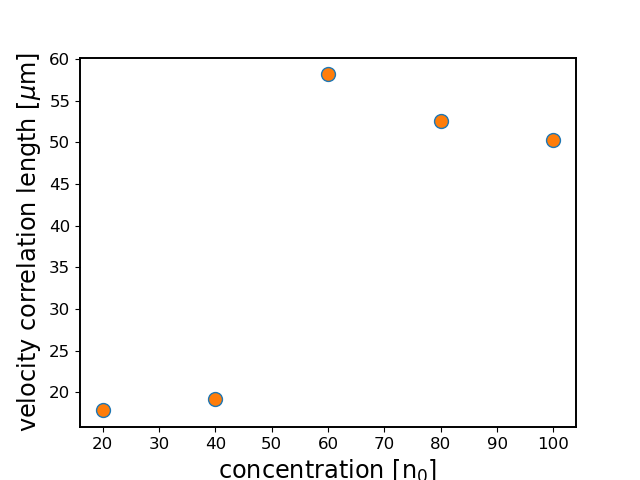

Text(0, 0.5, 'velocity correlation length [$\\mu$m]')

In [133]:
# plot correlation length
n = [20, 40, 60, 80, 100]
plt.plot(n, np.array(clV)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('velocity correlation length [$\mu$m]')

#### Figure 5 - what drives concentration fluctuations?
* concentration field $c$
* source field $\nabla \cdot (c\boldsymbol{n})$

##### Derive the numerical form of source field $\nabla \cdot (c\boldsymbol{n})$
<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
$$\partial_icn_i=c\partial_in_i+n_i\partial_ic$$

$$ \nabla \cdot (c\boldsymbol{n}) = c_{x,y}\frac{n^x_{x+1,y}-n^x_{x,y}}{1} + n^x_{x, y}\frac{c_{x+1, y}-c_{x, y}}{1}+$$

$$  c_{x,y}\frac{n^y_{x,y+1}-n^y_{x,y}}{1} + n^y_{x, y}\frac{c_{x, y+1}-c_{x, y}}{1}$$

assume the unit of $c$ is n$_0$, the unit of $\nabla$ is $l_{step}^{-1}$,  $\nabla \cdot (c\boldsymbol{n})$ has a unit of n$_0l_{step}^{-1}$.

Here, the absolute value of concentration $c$ is needed, which is not accessible experimentally due to unknown $I_0$ in Beer-Lambert's Law. Nonetheless, we have information on the relative concentration at different places. This allow us to depict the concentration distribution qualitatively. 

Assume that $I_0=255$.

In [32]:
# load data
pivData = pd.read_csv(r'D:\Wei\Dynamics_raw\piv_result\80\900-901.csv')
img = io.imread(r'D:\Wei\Dynamics_raw\80\900.tif')
bp = bpass(img, 3, 100)
bp_mh = match_hist(bp, img)
winsize = 50
step = 25
X, Y, I = divide_windows(bp_mh, windowsize=[winsize, winsize], step=step)

<IPython.core.display.Javascript object>


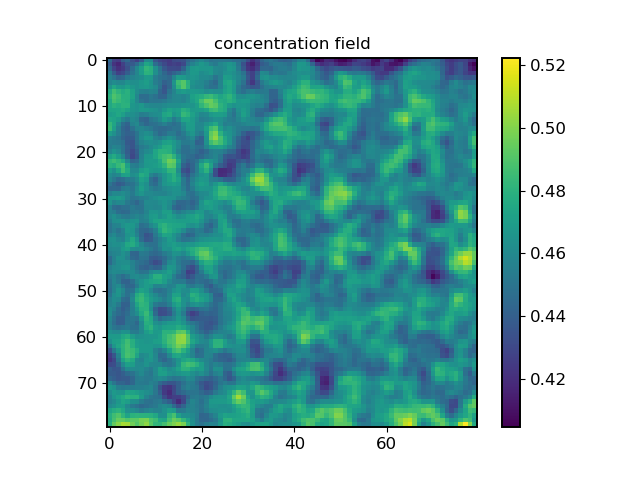

In [40]:
# concentration field
I0 = 255
c = np.log(I0/I)
plt.imshow(c)
plt.title('concentration field')
plt.colorbar()

In [26]:
row, col = I.shape
nx = np.array(pivData.u / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
ny = np.array(pivData.v / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
divcn = np.zeros(I.shape)
for x in range(0, col-1):
    for y in range(0, row-1):
        divcn[y, x] = c[y, x] * (nx[y,x+1] - nx[y,x]) + nx[y,x] * (c[y,x+1] - c[y,x]) + \
                      c[y, x] * (ny[y+1,x] - ny[y,x]) + ny[y,x] * (c[y+1,x] - c[y,x])

<IPython.core.display.Javascript object>


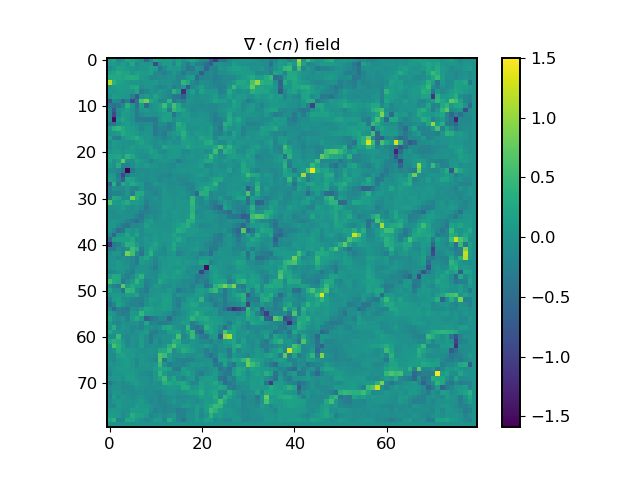

In [41]:
plt.imshow(divcn)
plt.title('$\\nabla\cdot(cn)$ field')
plt.colorbar()

In [139]:
pivData.u.max() * 0.033

3.9532863458804344